In [164]:
import torch
import torch.nn.functional as F
from torchvision.transforms import Grayscale

In [165]:
def get_gaussian_kernel(sigma, also_dg=False, radius=None):
    # order only 0 or 1
    
    if radius is None:
        radius = max(int(4*sigma + 0.5), 1)  # similar to scipy _gaussian_kernel1d but never smaller than 1
    x = torch.arange(-radius, radius+1)
    
    sigma2 = sigma * sigma
    phi_x = torch.exp(-0.5 / sigma2 * x**2)
    phi_x = phi_x / phi_x.sum()
    
    if also_dg:
        return phi_x, phi_x * -x / sigma2
    else:
        return phi_x


In [166]:
def structure_tensor(im, sigma, rho):
    '''
    Image is (1,H,W) torch tensor, st is (3,H,W) torch tensor.
    '''
    g, dg = get_gaussian_kernel(sigma, also_dg=True)
    h = (1, 1, -1, 1)
    w = (1, 1, 1, -1)
    Ix = F.conv2d(im.unsqueeze(0), dg.reshape(h), padding='valid')
    Ix = F.conv2d(Ix, g.reshape(w), padding='valid')
    Iy = F.conv2d(im.unsqueeze(0), g.reshape(h), padding='valid')
    Iy = F.conv2d(Iy, dg.reshape(w), padding='valid')
    
    k = get_gaussian_kernel(rho)
    Jxx = F.conv2d(Ix ** 2, k.reshape(h), padding='same')
    Jxx = F.conv2d(Jxx, k.reshape(w), padding='same')
    Jyy = F.conv2d(Iy ** 2, k.reshape(h), padding='same')
    Jyy = F.conv2d(Jyy, k.reshape(w), padding='same')
    Jxy = F.conv2d(Ix * Iy, k.reshape(h), padding='same')
    Jxy = F.conv2d(Jxy, k.reshape(w), padding='same')
    
    S = torch.cat((Jxx.squeeze(0), Jyy.squeeze(0), Jxy.squeeze(0)), dim=0)
    return S

In [167]:
def normalize(S):
    d = S[0]*S[1] - S[2]**2
    o = (d==0)  # TODO, deal with this somehow?!
    i  = o.sum()
    if i>0:
        print(f'We have {o.sum()} determinants which are zeros!')
    #S[..., o] = torch.Tensor([[1],[1],[0]])  # identity matrix
    #d[o] = 1
    return S/torch.sqrt(d)

def compute_invS1xS2(S1, S2, normalized=False):
    ''' Pixelwise inv(S1)*S2 for two symmetric 2x2 matrices.'''
    
    if not normalized:
        S1 = normalize(S1)
        S2 = normalize(S2)
    A = (S1[1]*S2[0] - S1[2]*S2[2])  # Element M_11
    B = (S1[0]*S2[1] - S1[2]*S2[2])  # Element M_22
    C = (S1[1]*S2[2] - S1[2]*S2[1])  # Element M_12
    D = (S1[0]*S2[2] - S1[2]*S2[0])  # Element M_21
    return torch.stack((A, B, C, D), dim=1)

def compute_eigenvalues(M):
    ''' Pixelwise eigenvalues of 2x2 matrix.'''
    
    ApB = M[0] + M[1]
    discriminant = ApB ** 2 - 4 * (M[0] * M[1] - M[2] * M[3]) # THIS SHOULD ALWAYS BE > 0
    #i = (discriminant<0).sum()
    #if i>0:
    #    print(f'We have {i} negative discriminants!')
    discriminant = torch.clamp(discriminant, min=0)  # TODO, better way of handling this?
    r = torch.sqrt(discriminant)
    l1 = 0.5*(ApB - r)
    l2 = 0.5*(ApB + r)
    return torch.stack((l1, l2), dim=1)
    
def compute_distance(L):
    ''' Pixelwise Riemannian distance from eigenvalues'''
    
    #i = (L<1).sum()
    #if i>0:
    #    print(f'We have {i} eigenvalues smaller than 1!')
    L = torch.clamp(L, min=1)  # TODO, better way of handling this?
    L = torch.log(L)
    L = L**2
    d = L.sum(dim=0)
    return torch.sqrt(d)

In [168]:
def st_loss_function(batch1, batch2, sigma, rho):
    loss = torch.tensor([0])
    for b1, b2 in zip(batch1, batch2):
        S1 = structure_tensor(b1, sigma, rho) # ok
        S2 = structure_tensor(b2, sigma, rho) # ok
        
        M = compute_invS1xS2(S1, S2, normalized=False)
        L = compute_eigenvalues(M)
        d = compute_distance(L)
        loss = loss + d.sum()
    return loss


In [169]:
from torch.utils.data import DataLoader
import sys
sys.path.append("..")
from dataset import TestImageDataset

TEST_GT_IMAGES_DIR = F"/work3/s204163/data/Set5/GTmod12"    # Test HR images
TEST_LR_IMAGES_DIR = f"/work3/s204163/data/Set5/LRbicx4"    # Test downscaled images
test_datasets = TestImageDataset(TEST_GT_IMAGES_DIR, TEST_LR_IMAGES_DIR)

test_dataloader = DataLoader(
    dataset = test_datasets,
    batch_size = 1,
    shuffle = False,
    num_workers = 1,
    pin_memory = True,
    drop_last = False,
    persistent_workers = True,
)

tensor([239.1830])


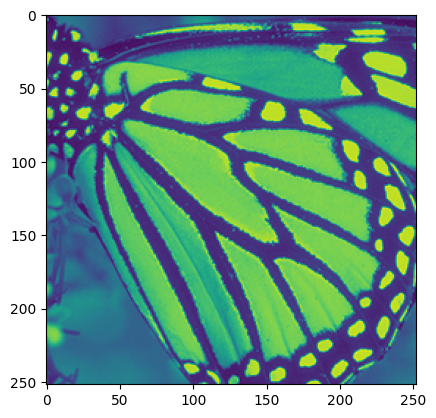

tensor([274.4723])


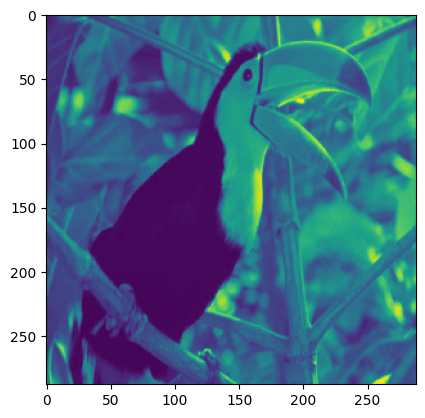

We have 30 determinants which are zeros!
We have 26 determinants which are zeros!
tensor([262.7092])


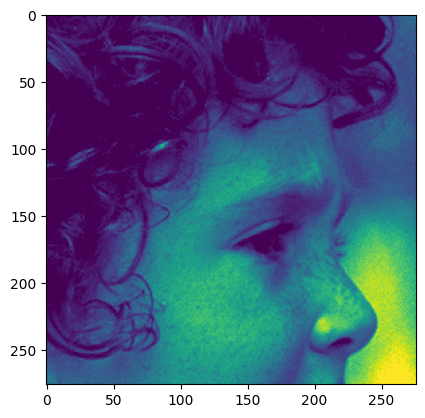

tensor([486.2080])


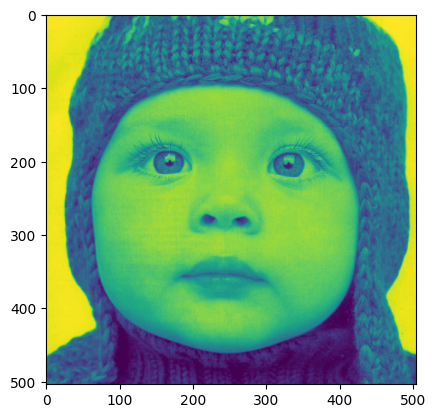

We have 11 determinants which are zeros!
We have 12 determinants which are zeros!
tensor([nan])


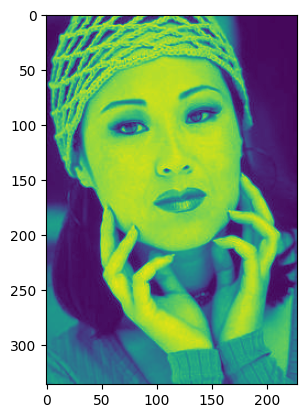

In [180]:
for i, (gt, lr) in enumerate(test_dataloader):
    gt = Grayscale()(gt)
    sigma = 1
    rho = 2.5
    # a = structure_tensor(gt.squeeze(), sigma, rho)
    # b = structure_tensor(gt.squeeze() * 0.5, 1, 10) # ok
    # print(a.shape)
    # M = compute_invS1xS2(a, b, normalized=False)
    # L = compute_eigenvalues(M)
    # print(L)
    # d = compute_distance(L)
    # # print(d)
    # loss = d.sum()
    # print(loss)
    print(st_loss_function(gt, gt*0.8, sigma, rho))
    plt.imshow(gt.squeeze())
    plt.show()


In [171]:
# tensor([239.1830])
# tensor([274.4723])
# tensor([262.7091])
# tensor([486.2080])
# tensor([215.6568])

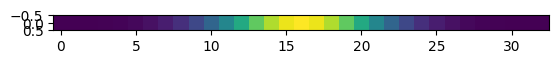

In [172]:
import matplotlib.pyplot as plt
plt.imshow(get_gaussian_kernel(4).reshape(1,-1))
plt.show()

In [186]:
from torch import nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.cl1 = nn.Linear(25, 60)
        self.cl2 = nn.Linear(60, 16)
        self.fc1 = nn.Linear(16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.relu(self.cl1(x))
        x = F.relu(self.cl2(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model = MyModel()
model.fc2.register_forward_hook(get_activation('fc2'))
x = torch.randn(1, 25)
output = model(x)
print(activation['fc2'][:1,:3])
x = torch.randn(1, 25)
output = model(x)
print(activation['fc2'][:1,:3])

tensor([[-0.1692, -0.0393, -0.0771]])
tensor([[-0.2173, -0.0083, -0.0890]])
